In [ ]:
# # Download dataset
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np

# Load Dataset
abnormal_scans = np.load('pneumonia.npy')
normal_scans = np.load('normal.npy')

print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
print(f'Shape of normal_scans: {normal_scans.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.

abnormal_labels = np.ones((abnormal_scans.shape[0],))
normal_labels = np.zeros((normal_scans.shape[0],))

split_point = 800

x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

--2023-10-15 15:44:19--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65536128 (62M) [application/octet-stream]
Saving to: ‘normal.npy.4’

normal.npy.4        100%[===================>]  62.50M   330MB/s    in 0.2s    

2023-10-15 15:44:21 (330 MB/s) - ‘normal.npy.4’ saved [65536128/65536128]

--2023-10-15 15:44:21--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Le

In [ ]:
import torch.nn as nn

# Model in Lab 2
# model = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(256*256*1, 256),
#     nn.ReLU(),
#     nn.Linear(256, 1)
# ).cuda()

model = nn.Sequential(
    nn.Flatten(),

    nn.Linear(256*256*1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 3)
).cuda()

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=64, bias=True)
  (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.5, inplace=False)
  (13): Linear(in_features=64, out_features=3, bias=True)
)


In [ ]:
#C Tarining the Neural Network

import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 10
best_val_loss = float('inf')

# Criterion and Optimizer
criterion = nn.CrossEntropyLoss()             #nn.BCEWithLogitsLoss→nn.CrossEntropyLoss
optimizer = optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
# lr_scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.long()              # Changed from labels.float().unsqueeze(1) for BCE loss

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)       # Changed from torch.sigmoid(outputs) > 0.5 for BCE loss
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in train_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()              # Changed from labels.float().unsqueeze(1) for BCE loss

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            train_predicted = outputs.argmax(-1)      # Changed from torch.sigmoid(outputs) > 0.5 for BCE loss
            correct += (train_predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'model_classification01.pth')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)


Epoch 1/10, Train Loss: 1.0927, Train Accuracy: 39.38%, Val Loss: 3.3383, Val Accuracy: 64.19%
Epoch 2/10, Train Loss: 1.0189, Train Accuracy: 47.25%, Val Loss: 3.3755, Val Accuracy: 81.06%
Epoch 3/10, Train Loss: 0.9702, Train Accuracy: 53.38%, Val Loss: 3.4707, Val Accuracy: 67.31%
Epoch 4/10, Train Loss: 0.9672, Train Accuracy: 51.75%, Val Loss: 3.6169, Val Accuracy: 72.56%
Epoch 5/10, Train Loss: 0.9562, Train Accuracy: 52.69%, Val Loss: 3.3808, Val Accuracy: 68.56%
Epoch 6/10, Train Loss: 0.9291, Train Accuracy: 56.75%, Val Loss: 3.3048, Val Accuracy: 85.38%
Epoch 7/10, Train Loss: 0.9116, Train Accuracy: 57.75%, Val Loss: 3.0121, Val Accuracy: 83.62%
Epoch 8/10, Train Loss: 0.8894, Train Accuracy: 59.56%, Val Loss: 3.3880, Val Accuracy: 81.75%
Epoch 9/10, Train Loss: 0.8682, Train Accuracy: 61.00%, Val Loss: 3.1913, Val Accuracy: 87.31%
Epoch 10/10, Train Loss: 0.8613, Train Accuracy: 62.50%, Val Loss: 3.1392, Val Accuracy: 91.69%


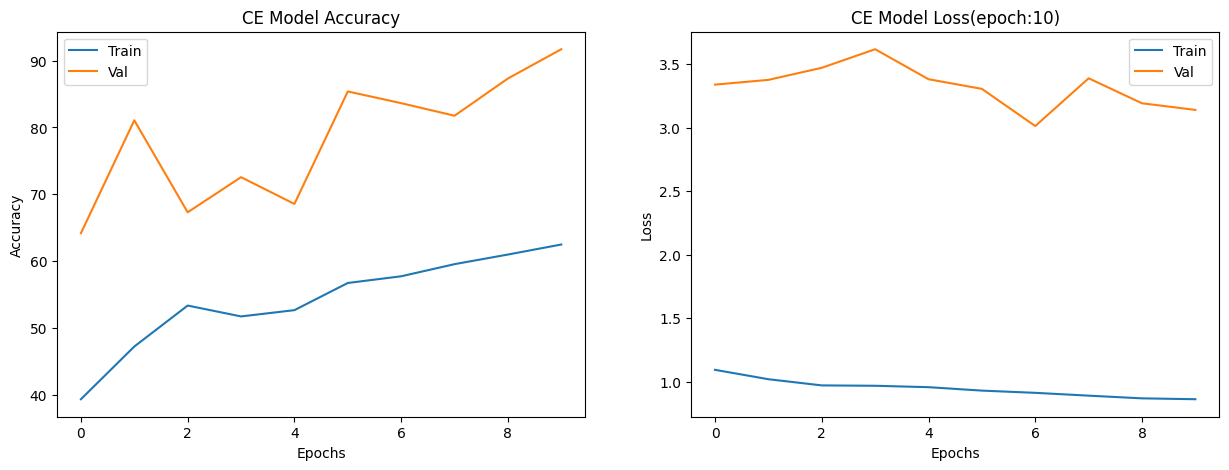

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('CE Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('CE Model Loss(epoch:10)')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

#CE epoch 30

In [ ]:
#C Tarining the Neural Network

import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 30
best_val_loss = float('inf')

# Criterion and Optimizer
criterion = nn.CrossEntropyLoss()             #nn.BCEWithLogitsLoss→nn.CrossEntropyLoss
optimizer = optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
# lr_scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.long()              # Changed from labels.float().unsqueeze(1) for BCE loss

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)       # Changed from torch.sigmoid(outputs) > 0.5 for BCE loss
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in train_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()              # Changed from labels.float().unsqueeze(1) for BCE loss

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            train_predicted = outputs.argmax(-1)      # Changed from torch.sigmoid(outputs) > 0.5 for BCE loss
            correct += (train_predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'model_classification01.pth')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)


Epoch 1/30, Train Loss: 0.8479, Train Accuracy: 64.25%, Val Loss: 2.8677, Val Accuracy: 84.00%
Epoch 2/30, Train Loss: 0.8416, Train Accuracy: 63.12%, Val Loss: 2.8434, Val Accuracy: 94.25%
Epoch 3/30, Train Loss: 0.8161, Train Accuracy: 68.44%, Val Loss: 2.7273, Val Accuracy: 92.25%
Epoch 4/30, Train Loss: 0.8089, Train Accuracy: 67.31%, Val Loss: 2.9954, Val Accuracy: 89.00%
Epoch 5/30, Train Loss: 0.8015, Train Accuracy: 71.31%, Val Loss: 3.0058, Val Accuracy: 94.31%
Epoch 6/30, Train Loss: 0.7997, Train Accuracy: 68.88%, Val Loss: 2.9736, Val Accuracy: 95.50%
Epoch 7/30, Train Loss: 0.7789, Train Accuracy: 72.19%, Val Loss: 2.7797, Val Accuracy: 93.94%
Epoch 8/30, Train Loss: 0.7766, Train Accuracy: 73.38%, Val Loss: 2.5607, Val Accuracy: 96.25%
Epoch 9/30, Train Loss: 0.7455, Train Accuracy: 75.69%, Val Loss: 2.5589, Val Accuracy: 95.75%
Epoch 10/30, Train Loss: 0.7335, Train Accuracy: 75.94%, Val Loss: 2.7657, Val Accuracy: 94.38%
Epoch 11/30, Train Loss: 0.7386, Train Accuracy: 

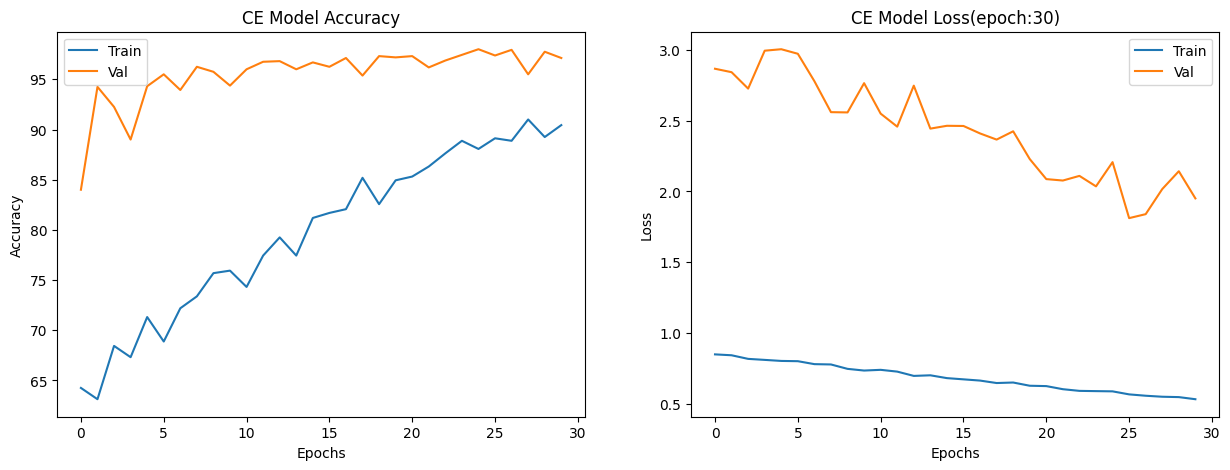

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('CE Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('CE Model Loss(epoch:30)')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

#BCE

In [ ]:
import torch.nn as nn

# Model in Lab 2
# model = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(256*256*1, 256),
#     nn.ReLU(),
#     nn.Linear(256, 1)
# ).cuda()

model = nn.Sequential(
    nn.Flatten(),

    nn.Linear(256*256*1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 1)
).cuda()

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=64, bias=True)
  (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.5, inplace=False)
  (13): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 30
best_val_loss = float('inf')

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
# lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.float().unsqueeze(1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = torch.sigmoid(outputs) > 0.5
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.float().unsqueeze(1)

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = torch.sigmoid(outputs) > 0.5
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'model_classification02.pth')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

Epoch 1/30, Train Loss: 0.6426, Train Accuracy: 63.75%, Val Loss: 0.6030, Val Accuracy: 85.25%
Epoch 2/30, Train Loss: 0.6048, Train Accuracy: 70.00%, Val Loss: 0.5701, Val Accuracy: 90.00%
Epoch 3/30, Train Loss: 0.5962, Train Accuracy: 70.81%, Val Loss: 0.5352, Val Accuracy: 91.25%
Epoch 4/30, Train Loss: 0.5725, Train Accuracy: 75.44%, Val Loss: 0.5069, Val Accuracy: 94.25%
Epoch 5/30, Train Loss: 0.5665, Train Accuracy: 75.06%, Val Loss: 0.5371, Val Accuracy: 89.75%
Epoch 6/30, Train Loss: 0.5621, Train Accuracy: 76.31%, Val Loss: 0.5333, Val Accuracy: 91.25%
Epoch 7/30, Train Loss: 0.5565, Train Accuracy: 76.75%, Val Loss: 0.5046, Val Accuracy: 94.00%
Epoch 8/30, Train Loss: 0.5479, Train Accuracy: 77.69%, Val Loss: 0.4984, Val Accuracy: 93.25%
Epoch 9/30, Train Loss: 0.5408, Train Accuracy: 78.31%, Val Loss: 0.4912, Val Accuracy: 93.25%
Epoch 10/30, Train Loss: 0.5370, Train Accuracy: 79.00%, Val Loss: 0.4927, Val Accuracy: 93.50%
Epoch 11/30, Train Loss: 0.5188, Train Accuracy: 

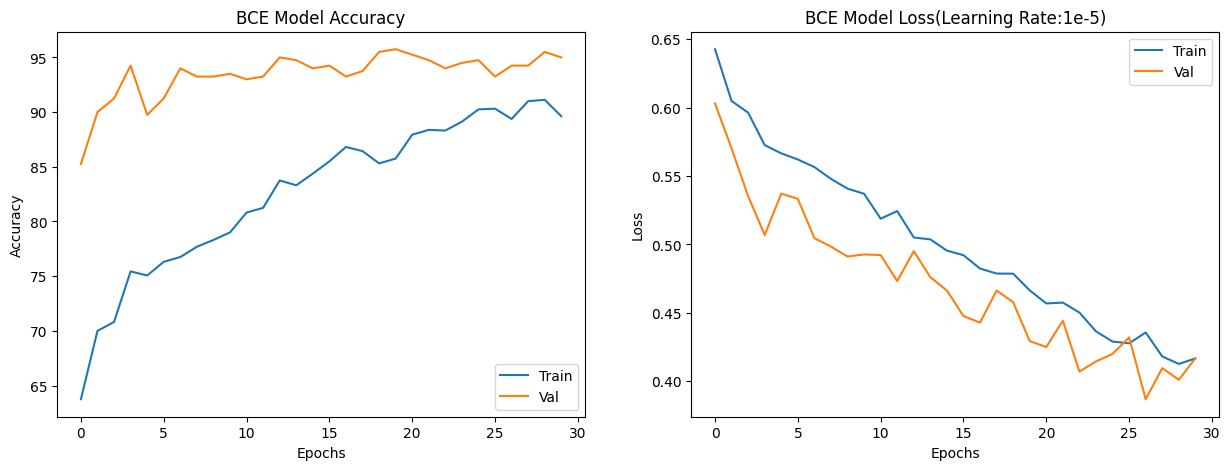

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('BCE Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('BCE Model Loss(Learning Rate:1e-5)')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

#BCE learning rate 1e-4

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 30
best_val_loss = float('inf')

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
# lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.float().unsqueeze(1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = torch.sigmoid(outputs) > 0.5
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.float().unsqueeze(1)

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = torch.sigmoid(outputs) > 0.5
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'model_classification02.pth')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

Epoch 1/30, Train Loss: 0.4391, Train Accuracy: 86.25%, Val Loss: 0.4130, Val Accuracy: 93.00%
Epoch 2/30, Train Loss: 0.3813, Train Accuracy: 90.62%, Val Loss: 0.3994, Val Accuracy: 87.25%
Epoch 3/30, Train Loss: 0.3438, Train Accuracy: 92.12%, Val Loss: 0.3705, Val Accuracy: 92.25%
Epoch 4/30, Train Loss: 0.3151, Train Accuracy: 92.56%, Val Loss: 0.2972, Val Accuracy: 92.50%
Epoch 5/30, Train Loss: 0.2831, Train Accuracy: 94.06%, Val Loss: 0.2775, Val Accuracy: 93.25%
Epoch 6/30, Train Loss: 0.2605, Train Accuracy: 94.19%, Val Loss: 0.2601, Val Accuracy: 94.75%
Epoch 7/30, Train Loss: 0.2427, Train Accuracy: 94.62%, Val Loss: 0.2080, Val Accuracy: 94.00%
Epoch 8/30, Train Loss: 0.2195, Train Accuracy: 96.06%, Val Loss: 0.2463, Val Accuracy: 92.50%
Epoch 9/30, Train Loss: 0.2056, Train Accuracy: 95.31%, Val Loss: 0.2164, Val Accuracy: 94.25%
Epoch 10/30, Train Loss: 0.1992, Train Accuracy: 95.44%, Val Loss: 0.3624, Val Accuracy: 83.50%
Epoch 11/30, Train Loss: 0.1857, Train Accuracy: 

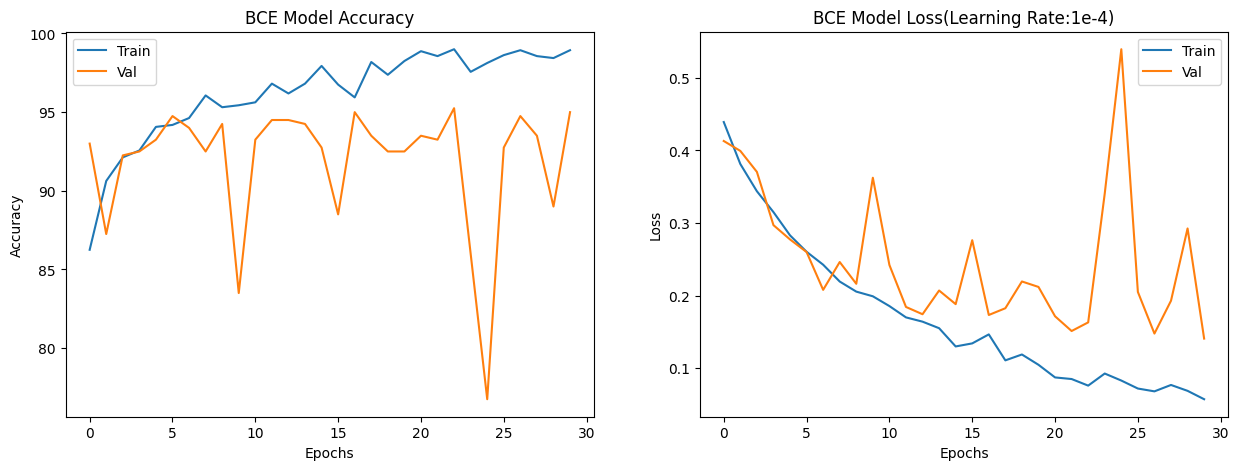

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('BCE Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('BCE Model Loss(Learning Rate:1e-4)')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

#BCE 1e-3

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 30
best_val_loss = float('inf')

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
# lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.float().unsqueeze(1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = torch.sigmoid(outputs) > 0.5
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.float().unsqueeze(1)

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = torch.sigmoid(outputs) > 0.5
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'model_classification02.pth')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

Epoch 1/30, Train Loss: 0.0385, Train Accuracy: 98.75%, Val Loss: 0.3129, Val Accuracy: 90.25%
Epoch 2/30, Train Loss: 0.0398, Train Accuracy: 98.62%, Val Loss: 0.5714, Val Accuracy: 83.50%
Epoch 3/30, Train Loss: 0.0477, Train Accuracy: 98.44%, Val Loss: 0.1188, Val Accuracy: 97.00%
Epoch 4/30, Train Loss: 0.0419, Train Accuracy: 98.50%, Val Loss: 0.1790, Val Accuracy: 94.75%
Epoch 5/30, Train Loss: 0.0757, Train Accuracy: 97.50%, Val Loss: 0.2224, Val Accuracy: 94.00%
Epoch 6/30, Train Loss: 0.0433, Train Accuracy: 98.50%, Val Loss: 0.5255, Val Accuracy: 87.50%
Epoch 7/30, Train Loss: 0.0340, Train Accuracy: 99.31%, Val Loss: 0.2775, Val Accuracy: 93.25%
Epoch 8/30, Train Loss: 0.0475, Train Accuracy: 98.56%, Val Loss: 0.2500, Val Accuracy: 92.50%
Epoch 9/30, Train Loss: 0.0331, Train Accuracy: 98.75%, Val Loss: 0.1411, Val Accuracy: 95.00%
Epoch 10/30, Train Loss: 0.0535, Train Accuracy: 98.31%, Val Loss: 0.2411, Val Accuracy: 92.50%
Epoch 11/30, Train Loss: 0.0471, Train Accuracy: 

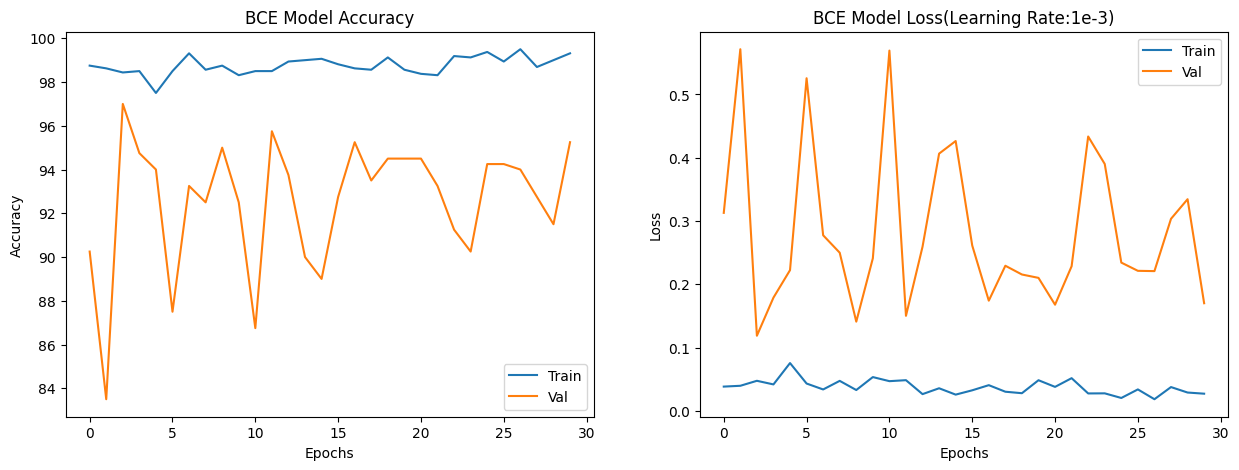

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('BCE Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('BCE Model Loss(Learning Rate:1e-3)')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 30
best_val_loss = float('inf')

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
# lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.float().unsqueeze(1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = torch.sigmoid(outputs) > 0.5
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.float().unsqueeze(1)

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = torch.sigmoid(outputs) > 0.5
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'model_classification02.pth')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

Epoch 1/30, Train Loss: 0.6988, Train Accuracy: 49.69%, Val Loss: 0.6931, Val Accuracy: 50.00%
Epoch 2/30, Train Loss: 0.7582, Train Accuracy: 51.38%, Val Loss: 0.6955, Val Accuracy: 50.00%
Epoch 3/30, Train Loss: 0.7036, Train Accuracy: 49.88%, Val Loss: 0.7291, Val Accuracy: 50.00%
Epoch 4/30, Train Loss: 0.7077, Train Accuracy: 50.81%, Val Loss: 0.7011, Val Accuracy: 50.00%
Epoch 5/30, Train Loss: 0.7048, Train Accuracy: 46.38%, Val Loss: 0.6958, Val Accuracy: 50.00%
Epoch 6/30, Train Loss: 0.7261, Train Accuracy: 50.12%, Val Loss: 0.6980, Val Accuracy: 50.00%
Epoch 7/30, Train Loss: 0.6993, Train Accuracy: 50.88%, Val Loss: 0.6989, Val Accuracy: 50.00%
Epoch 8/30, Train Loss: 0.7417, Train Accuracy: 51.12%, Val Loss: 0.7123, Val Accuracy: 50.00%
Epoch 9/30, Train Loss: 0.7031, Train Accuracy: 50.75%, Val Loss: 0.6924, Val Accuracy: 50.00%
Epoch 10/30, Train Loss: 0.7046, Train Accuracy: 51.88%, Val Loss: 0.6939, Val Accuracy: 50.00%
Epoch 11/30, Train Loss: 0.7113, Train Accuracy: 

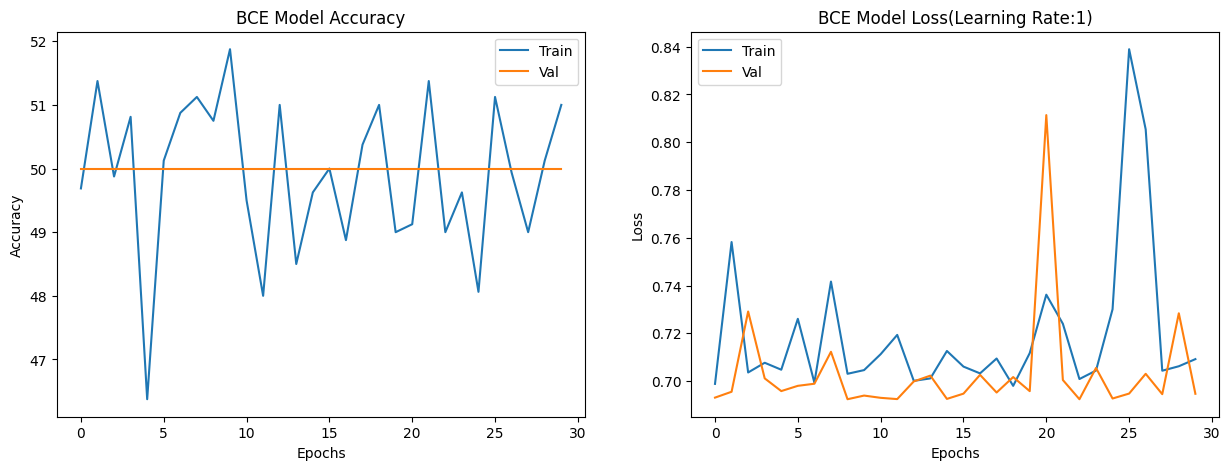

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('BCE Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('BCE Model Loss(Learning Rate:1)')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()